In [58]:
import sys
import io
import os
import numpy as np
import time
import pygame

# Imports des modules
from src.rl_environments.TwoRoundRPS import TwoRoundRPSEnvironment
from src.rl_environments.line_world import LineWorld
from src.rl_environments.grid_world import GridWorld
from src.rl_environments.monty_hall_interactive import MontyHallInteractive
from src.rl_environments.monty_hall2_stepbystep import MontyHall2StepByStep
from src.rl_environments.monty_hall2 import MontyHall2
from src.rl_environments.TwoRoundRPS import TwoRoundRPSEnvironment
from src.rl_algorithms.q_learning import QLearning
from src.rl_algorithms.policy_iteration import PolicyIteration
from src.rl_algorithms.value_iteration import ValueIteration
from src.rl_algorithms.monte_carlo_es import MonteCarloES
from src.rl_algorithms.on_policy_first_visit_mc_control import OnPolicyFirstVisitMCControl
from src.rl_algorithms.off_policy_mc_control import OffPolicyMCControl
from src.rl_algorithms.sarsa import SARSA
from src.rl_algorithms.dyna_q import DynaQ
from utils.agent import Agent
from utils.human_player import HumanPlayer

Stratégie optimale: se servir de ce que l'agent a joué au 1er round pour choisir une action qui le fera gagner ou obtenir un match nul. Au round 1, aucue stratégie car l'adversaire joue de manière aléatoire

Ce qu'il faut regarder dans la table Q:
Les états 1,2,3 contiennent la même informations.
De même que les états 4,5,6 et les états 7,8,9.
Il faut juste vérifier que la bonne action est prise dépendamment de ce l'agent a joué au round 1

Explication des états:
- Etat 0: Avant round 1
Après round 1
- Etats 1,2,3: agent joue pierre (adversaire joue pierre, feuille ciseaux)
- Etats 4,5,6: agent joue feuille
- Etats 7,8,9: agent joue ciseaux
- Etat 10: fin du jeu

In [2]:
env_rps = TwoRoundRPSEnvironment()

# Policy iteration

Les hyperparamètres:

- Facteur d’actualisation (discount factor) γ∈[0,1]
Le plus important !
Détermine l’importance accordée aux récompenses futures.
Valeurs typiques :
γ=0.9 : récompenses futures sont importantes
γ=0.0 : on ne considère que la récompense immédiate
γ=0.99 : apprentissage à long terme
Il dépend à la fois de l'algorithme et de l'environnement. Pour l'algorithme:
  γ≈0 → agent myope, il ne se préoccupe que des gains immédiats.
  γ≈1 → agent patient, il prend en compte les conséquences à long terme.


- Seuil de convergence pour l’évaluation de la politique θ (dans les implémentations itératives)
Utilisé dans l’évaluation de la politique avec la méthode itérative (au lieu de résolution exacte).
On arrête les itérations si :
max( ∣Vk+1(s)−Vk(s)∣ ) < θ
Valeurs typiques : θ=10^−3  ou  10^−6
 
- Nombre max d’itérations (moins essentiel)
Sert à empêcher une boucle infinie si convergence trop lente.
Par exemple : max_policy_eval_iters = 1000 

In [27]:
# on choisit gamma=1 car il faut pleinement prendre en compte le 2ème round mais sans "actualisation" inutile.
config_pi = {
    'gamma': 0.999999,
    'theta': 0.00001,
    'max_iterations': 1000
}
    
algorithm_pi_rps = PolicyIteration.from_config(config_pi, env_rps)
algorithm_pi_rps.train(env_rps, num_episodes=1000, verbose=False)

agent_pi_rps = Agent(algorithm_pi_rps, env_rps, "Agent_pi_rps")

✅ Agent créé: Agent_pi_rps


In [4]:
print(algorithm_pi_rps.visualize_q_table())


Q-TABLE - PolicyIteration
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     1.00         1.00         1.00         0         1.00      
1     0.00         1.00         -1.00        1         1.00      
2     0.00         1.00         -1.00        1         1.00      
3     0.00         1.00         -1.00        1         1.00      
4     -1.00        0.00         1.00         2         1.00      
5     -1.00        0.00         1.00         2         1.00      
6     -1.00        0.00         1.00         2         1.00      
7     1.00         -1.00        0.00         0         1.00      
8     1.00         -1.00        0.00         0         1.00      
9     1.00         -1.00        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [5]:
agent_pi_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=1000)


📊 ÉVALUATION: Agent_pi_rps
Épisodes d'évaluation: 1000
Progression: 10% - Récompense moyenne: 1.03
Progression: 20% - Récompense moyenne: 0.96
Progression: 30% - Récompense moyenne: 0.97
Progression: 40% - Récompense moyenne: 0.97
Progression: 50% - Récompense moyenne: 0.98
Progression: 60% - Récompense moyenne: 0.99
Progression: 70% - Récompense moyenne: 1.01
Progression: 80% - Récompense moyenne: 1.01
Progression: 90% - Récompense moyenne: 1.01
Progression: 100% - Récompense moyenne: 1.00

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 1.00 ± 0.82
Taux de succès: 66.2% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.02s



{'agent_name': 'Agent_pi_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 1000,
 'avg_reward': np.float64(1.0),
 'std_reward': np.float64(0.8221921916437787),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.662,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.016811847686767578,
 'timestamp': '2025-07-20T02:11:39.317770'}

L'agent apprend parfaitement, il y convergence vers la stratégie optimale au bout de la 3ème itération car la stratégie optimale est relativement simple
Récompense moyenne de 1 et Taux de réussite à 66.2%

In [8]:
#Sauvegarde modèle
algorithm_pi_rps.save_model(filepath = "outputs/rps/modèle/policy_iteration.pkl")

#Sauvegarde résultats
agent_pi_rps.save_results(filepath = "outputs/rps/results/policy_iteration")

✅ Résultats sauvegardés: outputs/rps/results/policy_iteration_agent_results.pkl


True

In [83]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = PolicyIteration(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/policy_iteration.pkl")
agent_pi_rps_ent = Agent(algo_sauv, env_rps, "Agent_pi_rps_entraine")

✅ Agent créé: Agent_pi_rps_entraine


In [89]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_pi_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_policy_iteration.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())

# Value iteration

In [3]:
config_vi = {
    'gamma': 0.9,
    'theta': 1e-6,
    'max_iterations': 1000
}
    
algorithm_vi_rps = ValueIteration.from_config(config_vi, env_rps)
algorithm_vi_rps.train(env_rps, num_episodes=1000, verbose=False)

{'iterations': 3,
 'final_delta': 0,
 'converged': True,
 'max_value': np.float64(1.0),
 'convergence_history': [{'iteration': 0,
   'delta': np.float64(1.0),
   'max_value': np.float64(1.0)},
  {'iteration': 1, 'delta': np.float64(0.9), 'max_value': np.float64(1.0)},
  {'iteration': 2, 'delta': 0, 'max_value': np.float64(1.0)}]}

In [4]:
agent_vi_rps = Agent(algorithm_vi_rps, env_rps, "Agent_vi_rps")

✅ Agent créé: Agent_vi_rps


In [5]:
print(algorithm_vi_rps.visualize_q_table())


Q-TABLE - ValueIteration
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.90         0.90         0.90         1         0.90      
1     0.00         1.00         -1.00        1         1.00      
2     0.00         1.00         -1.00        1         1.00      
3     0.00         1.00         -1.00        1         1.00      
4     -1.00        0.00         1.00         2         1.00      
5     -1.00        0.00         1.00         2         1.00      
6     -1.00        0.00         1.00         2         1.00      
7     1.00         -1.00        0.00         0         1.00      
8     1.00         -1.00        0.00         0         1.00      
9     1.00         -1.00        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [6]:
agent_vi_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=1000)


📊 ÉVALUATION: Agent_vi_rps
Épisodes d'évaluation: 1000
Progression: 10% - Récompense moyenne: 0.96
Progression: 20% - Récompense moyenne: 1.02
Progression: 30% - Récompense moyenne: 1.01
Progression: 40% - Récompense moyenne: 1.00
Progression: 50% - Récompense moyenne: 0.98
Progression: 60% - Récompense moyenne: 0.97
Progression: 70% - Récompense moyenne: 0.97
Progression: 80% - Récompense moyenne: 0.98
Progression: 90% - Récompense moyenne: 0.99
Progression: 100% - Récompense moyenne: 0.99

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 0.99 ± 0.80
Taux de succès: 67.7% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.04s



{'agent_name': 'Agent_vi_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 1000,
 'avg_reward': np.float64(0.993),
 'std_reward': np.float64(0.7993441061270171),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.677,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.04036521911621094,
 'timestamp': '2025-07-20T02:54:59.536295'}

Politique optimale trouvée en 3 itérations
Récompense moyenne de 0.99 et Taux de réussite à 67.7%

In [7]:
#Sauvegarde modèle
algorithm_vi_rps.save_model(filepath = "outputs/rps/modèle/value_iteration.pkl")

#Sauvegarde résultats
agent_vi_rps.save_results(filepath = "outputs/rps/results/value_iteration")

✅ Résultats sauvegardés: outputs/rps/results/value_iteration_agent_results.pkl


True

In [84]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = ValueIteration(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/value_iteration.pkl")
agent_vi_rps_ent = Agent(algo_sauv, env_rps, "Agent_vi_rps_entraine")

✅ Agent créé: Agent_vi_rps_entraine


In [90]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_vi_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_value_iteration.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())

# Monte carlo ES

γ=1 si l’on veut maximiser les récompenses totales sans dévaluation
Plus d’épisodes = meilleure estimation de Q(s,a), doit être assez grand pour garantir la convergence.

In [18]:
config_mce = {
    'gamma': 0.95,
    'epsilon': 0.1,
    'epsilon_decay': 0.995,
}
    
algorithm_mce_rps = MonteCarloES.from_config(config_mce, env_rps)
algorithm_mce_rps.train(env_rps, num_episodes=2000, verbose=False)

{'episodes': 2000,
 'final_avg_reward': np.float64(0.92),
 'final_epsilon': 0.01,
 'episode_rewards': [1.0,
  0.0,
  1.0,
  2.0,
  0.0,
  2.0,
  -1.0,
  0.0,
  0.0,
  2.0,
  0.0,
  0.0,
  2.0,
  1.0,
  2.0,
  -1.0,
  2.0,
  2.0,
  2.0,
  -1.0,
  0.0,
  2.0,
  0.0,
  0.0,
  -1.0,
  0.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  -1.0,
  -1.0,
  2.0,
  1.0,
  1.0,
  -2.0,
  -1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  -2.0,
  1.0,
  2.0,
  1.0,
  2.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  -2.0,
  2.0,
  0.0,
  2.0,
  -2.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  -1.0,
  1.0,
  1.0,
  2.0,
  0.0,
  0.0,
  2.0,
  0.0,
  1.0,
  1.0,
  0.0,
  2.0,
  -1.0,
  1.0,
  1.0,
  2.0,
  1.0,
  1.0,
  0.0,
  -1.0,
  0.0,
  -1.0,
  0.0,
  -1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  -1.0,
  1.0,
  2.0,
  -2.0,
  1.0,
  2.0,
  0.0,
  2.0,
  2.0,
  0.0,
  0.0,
  0.0,
  1.0,
  2.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  2.0,
  0.0,
  1.0,
  0.0,
  2.0,
  0.0,
  1.0,
  1.0,
  0.0,
  2.0,
  0.0,
  2.0,
  2.0,
  0.0,

In [19]:
agent_mce_rps = Agent(algorithm_mce_rps, env_rps, "Agent_mce_rps")

✅ Agent créé: Agent_mce_rps


In [20]:
print(algorithm_mce_rps.visualize_q_table())


Q-TABLE - MonteCarloES
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.91         0.91         0.88         0         0.91      
1     0.68         1.00         0.93         1         1.00      
2     0.86         1.01         0.85         1         1.01      
3     0.84         0.97         0.97         1         0.97      
4     0.69         0.72         0.95         2         0.95      
5     0.59         0.94         1.00         2         1.00      
6     0.89         0.83         0.98         2         0.98      
7     0.98         0.68         0.79         0         0.98      
8     0.98         0.89         0.85         0         0.98      
9     0.95         0.72         0.81         0         0.95      
10    0.00         0.00         0.00         0         0.00      



In [22]:
agent_mce_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=2000)


📊 ÉVALUATION: Agent_mce_rps
Épisodes d'évaluation: 2000
Progression: 10% - Récompense moyenne: 0.99
Progression: 20% - Récompense moyenne: 1.02
Progression: 30% - Récompense moyenne: 0.99
Progression: 40% - Récompense moyenne: 1.00
Progression: 50% - Récompense moyenne: 0.99
Progression: 60% - Récompense moyenne: 0.99
Progression: 70% - Récompense moyenne: 0.97
Progression: 80% - Récompense moyenne: 0.97
Progression: 90% - Récompense moyenne: 0.97
Progression: 100% - Récompense moyenne: 0.98

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 0.98 ± 0.82
Taux de succès: 65.5% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.03s



{'agent_name': 'Agent_mce_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 2000,
 'avg_reward': np.float64(0.9785),
 'std_reward': np.float64(0.8179472782520889),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.6545,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.030337095260620117,
 'timestamp': '2025-07-20T03:15:46.889284'}

[1.0, 0.0, 1.0, 2.0, 0.0, 2.0, -1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, -1.0, 2.0, 2.0, 2.0, -1.0, 0.0, 2.0, 0.0, 0.0, -1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 2.0, 1.0, 1.0, -2.0, -1.0, 1.0, 1.0, 0.0, 0.0, -2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, -2.0, 2.0, 0.0, 2.0, -2.0, 1.0, 1.0, 0.0, 0.0, 1.0, -1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, -1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 1.0, 1.0, 0.0, 1.0, 0.0, -1.0, 1.0, 2.0, -2.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, -2.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, -1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, -2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, -1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.

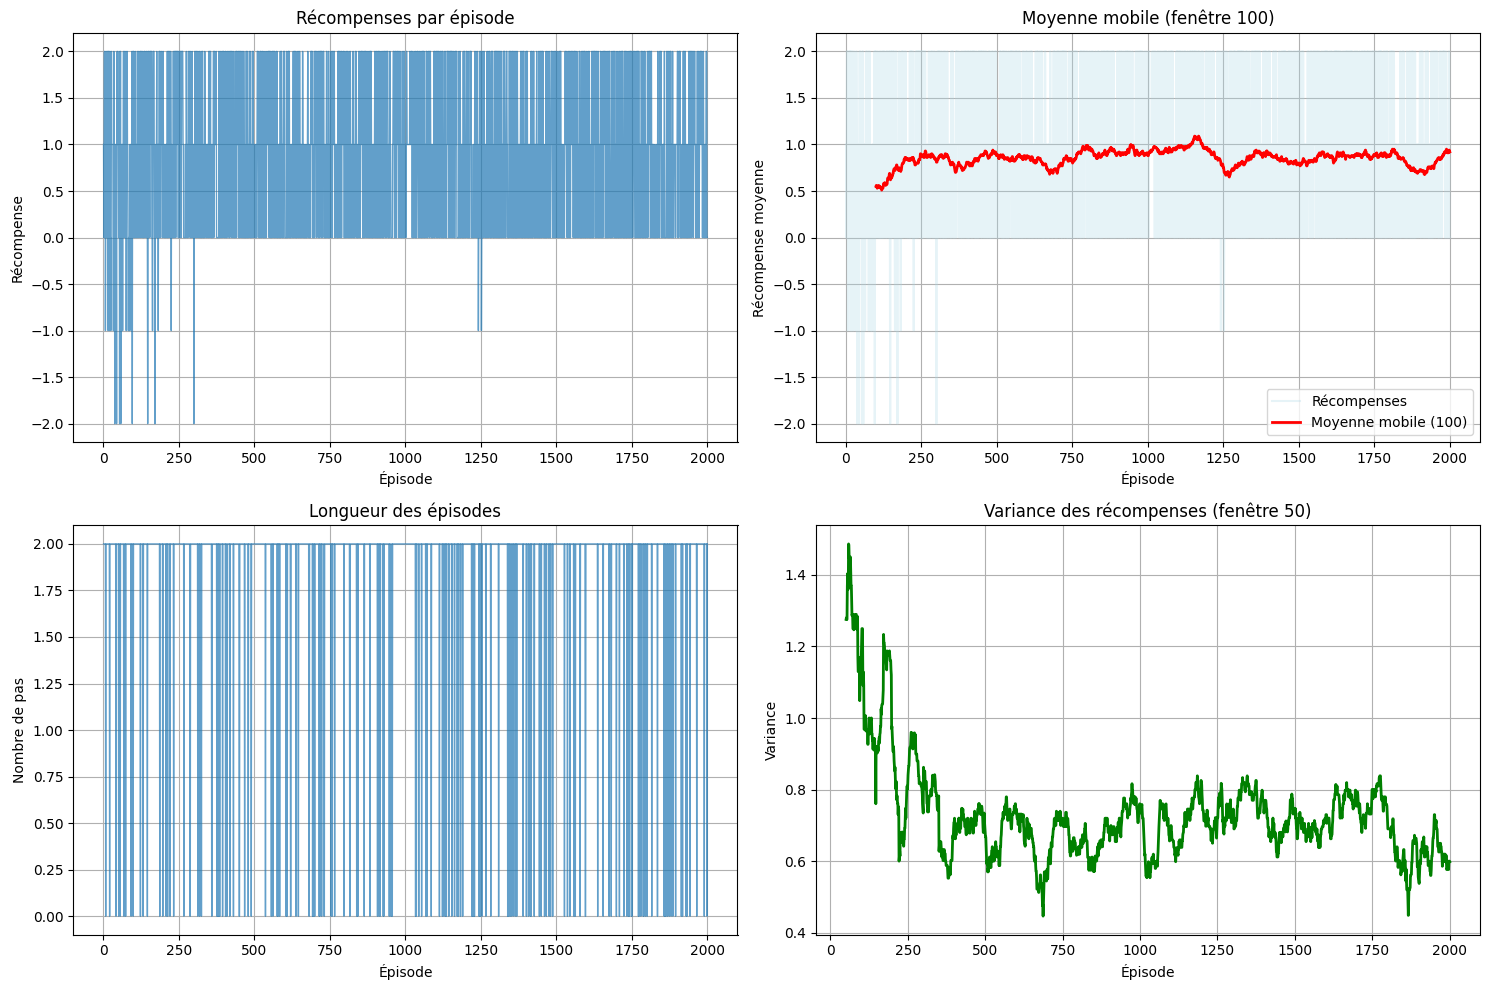

In [23]:
algorithm_mce_rps.plot_training_curves()

L'agent apprend très bien l'environnement
Valeurs de q table hautes mais pas très différents -> 
Dans certains états, les value functions sont très proches et dans d'autres on a une action dominante -> C’est typique d’un apprentissage basé sur l’expérience : certains états peuvent suggérer une préférence pour certaines actions
Le modèle converge rapidement et reste stable
Récompense moyenne de 0.98 et Taux de réussite à 65.5%

In [24]:
#Sauvegarde modèle
algorithm_mce_rps.save_model(filepath = "outputs/rps/modèle/monte_carlo_es.pkl")

#Sauvegarde résultats
agent_mce_rps.save_results(filepath = "outputs/rps/results/monte_carlo_es")

✅ Résultats sauvegardés: outputs/rps/results/monte_carlo_es_agent_results.pkl


True

In [85]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = MonteCarloES(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/monte_carlo_es.pkl")
agent_mce_rps_ent = Agent(algo_sauv, env_rps, "Agent_mce_rps_entraine")

✅ Agent créé: Agent_mce_rps_entraine


In [91]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_mce_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_monte_carlo_es.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())

# On policy Monte Carlo

In [28]:
config_on_mc = {
    'gamma': 0.95,
    'epsilon': 1,
    'epsilon_decay': 0.995,
}
    
algorithm_on_mc_rps = OnPolicyFirstVisitMCControl.from_config(config_on_mc, env_rps)
algorithm_on_mc_rps.train(env_rps, num_episodes=2000, verbose=False)

{'episodes': 2000,
 'final_avg_reward': np.float64(1.02),
 'final_epsilon': 0.01,
 'episode_rewards': [0.0,
  0.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  -1.0,
  -1.0,
  0.0,
  -1.0,
  1.0,
  -1.0,
  -2.0,
  0.0,
  2.0,
  -1.0,
  2.0,
  1.0,
  -1.0,
  0.0,
  0.0,
  -1.0,
  -2.0,
  -2.0,
  0.0,
  1.0,
  1.0,
  -2.0,
  1.0,
  -1.0,
  1.0,
  -1.0,
  -1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  -2.0,
  -1.0,
  -1.0,
  2.0,
  -1.0,
  -1.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0,
  0.0,
  2.0,
  -1.0,
  -1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  -2.0,
  1.0,
  0.0,
  1.0,
  0.0,
  -1.0,
  0.0,
  2.0,
  0.0,
  1.0,
  0.0,
  -1.0,
  -2.0,
  2.0,
  2.0,
  0.0,
  1.0,
  -1.0,
  2.0,
  -2.0,
  -1.0,
  -2.0,
  1.0,
  -1.0,
  2.0,
  0.0,
  0.0,
  -1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  -1.0,
  2.0,
  -1.0,
  2.0,
  0.0,
  0.0,
  1.0,
  1.0,
  -2.0,
  1.0,
  2.0,
  0.0,
  -1.0,
  0.0,
  0.0,
  -1.0,
  1.0,
  -2.0,
  0.0,
  -1.0,
  -1.0,
  

In [29]:
agent_on_mc_rps = Agent(algorithm_on_mc_rps, env_rps, "Agent_on_mc_rps")

✅ Agent créé: Agent_on_mc_rps


In [30]:
print(algorithm_on_mc_rps.visualize_q_table())


Q-TABLE - OnPolicyFirstVisitMC
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.24         0.40         0.83         2         0.83      
1     0.00         1.00         -1.00        1         1.00      
2     0.00         1.00         -1.00        1         1.00      
3     0.00         1.00         -1.00        1         1.00      
4     -1.00        0.00         1.00         2         1.00      
5     -1.00        0.00         1.00         2         1.00      
6     -1.00        0.00         1.00         2         1.00      
7     1.00         -1.00        0.00         0         1.00      
8     1.00         -1.00        0.00         0         1.00      
9     1.00         -1.00        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [31]:
agent_on_mc_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=2000)


📊 ÉVALUATION: Agent_on_mc_rps
Épisodes d'évaluation: 2000
Progression: 10% - Récompense moyenne: 1.00
Progression: 20% - Récompense moyenne: 0.96
Progression: 30% - Récompense moyenne: 0.97
Progression: 40% - Récompense moyenne: 0.97
Progression: 50% - Récompense moyenne: 0.97
Progression: 60% - Récompense moyenne: 0.97
Progression: 70% - Récompense moyenne: 0.98
Progression: 80% - Récompense moyenne: 0.98
Progression: 90% - Récompense moyenne: 0.98
Progression: 100% - Récompense moyenne: 0.97

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 0.97 ± 0.81
Taux de succès: 65.5% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.03s



{'agent_name': 'Agent_on_mc_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 2000,
 'avg_reward': np.float64(0.973),
 'std_reward': np.float64(0.8144145136231303),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.6545,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.033464908599853516,
 'timestamp': '2025-07-20T03:37:28.084662'}

[0.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, 1.0, -1.0, -2.0, 0.0, 2.0, -1.0, 2.0, 1.0, -1.0, 0.0, 0.0, -1.0, -2.0, -2.0, 0.0, 1.0, 1.0, -2.0, 1.0, -1.0, 1.0, -1.0, -1.0, 0.0, 0.0, 1.0, 0.0, -2.0, -1.0, -1.0, 2.0, -1.0, -1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0, 1.0, -2.0, 1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 2.0, 0.0, 1.0, 0.0, -1.0, -2.0, 2.0, 2.0, 0.0, 1.0, -1.0, 2.0, -2.0, -1.0, -2.0, 1.0, -1.0, 2.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, -1.0, 2.0, -1.0, 2.0, 0.0, 0.0, 1.0, 1.0, -2.0, 1.0, 2.0, 0.0, -1.0, 0.0, 0.0, -1.0, 1.0, -2.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1.0, 1.0, -1.0, 0.0, -1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -2.0, -2.0, -1.0, 1.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -2.0, 1.0, 1.0, -2.0, -2.0, -2.0, -1.0, 1.0, 0.0, -1.0, 0.0, 1.0, 0.0, -1.0, -1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, -2.0, -1.0, 0.0, 1.0, -2.0, 2.0, 2.0, 0.0, -1.0, -1.0, 2.0, 1.0, 0.0, 0.0, -2.0, 0.0

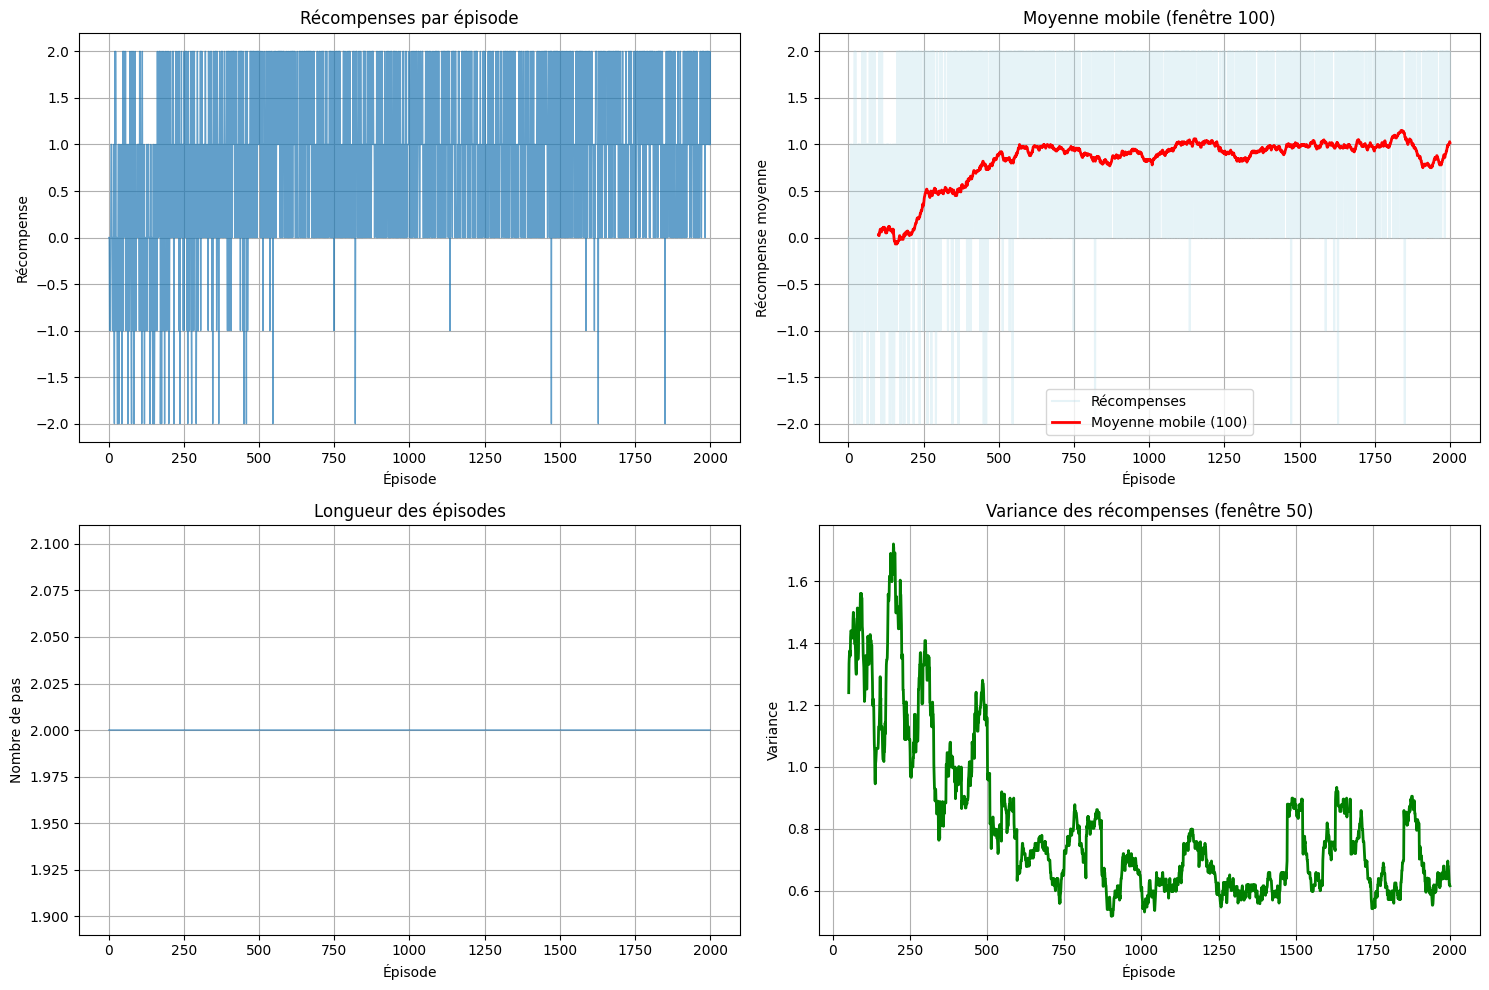

In [32]:
algorithm_on_mc_rps.plot_training_curves()

L'agent apprend très bien l'environnement
Le modèle converge rapidement et reste stable
Récompense moyenne de 0.97 et Taux de réussite à 65.5%
Pas grande différence avec MC_ES car on a un petit espace états-actions

In [33]:
#Sauvegarde modèle
algorithm_on_mc_rps.save_model(filepath = "outputs/rps/modèle/on_monte_carlo.pkl")

#Sauvegarde résultats
agent_on_mc_rps.save_results(filepath = "outputs/rps/results/on_monte_carlo")

✅ Résultats sauvegardés: outputs/rps/results/on_monte_carlo_agent_results.pkl


True

In [86]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = OnPolicyFirstVisitMCControl(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/on_monte_carlo.pkl")
agent_on_mc_rps_ent = Agent(algo_sauv, env_rps, "Agent_on_mc_rps_entraine")

✅ Agent créé: Agent_on_mc_rps_entraine


In [92]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_on_mc_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_on_monte_carlo.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())

# Off policy Monte Carlo

In [37]:
config_off_mc = {
    'gamma': 0.95,
    'epsilon': 1,
    'epsilon_decay': 0.995,
}
    
algorithm_off_mc_rps = OffPolicyMCControl.from_config(config_off_mc, env_rps)
algorithm_off_mc_rps.train(env_rps, num_episodes=2000, verbose=False)

{'episodes': 2000,
 'final_avg_reward': np.float64(0.91),
 'final_epsilon': 0.01,
 'episode_rewards': [2.0,
  1.0,
  2.0,
  2.0,
  -2.0,
  0.0,
  -1.0,
  0.0,
  1.0,
  -1.0,
  0.0,
  -1.0,
  1.0,
  -2.0,
  1.0,
  0.0,
  -1.0,
  -2.0,
  2.0,
  1.0,
  0.0,
  0.0,
  1.0,
  -1.0,
  2.0,
  -2.0,
  -1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  2.0,
  -2.0,
  -2.0,
  1.0,
  2.0,
  0.0,
  -2.0,
  0.0,
  2.0,
  -2.0,
  0.0,
  2.0,
  0.0,
  1.0,
  0.0,
  -2.0,
  -2.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  2.0,
  1.0,
  0.0,
  -2.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  -1.0,
  1.0,
  2.0,
  0.0,
  -1.0,
  0.0,
  1.0,
  1.0,
  -1.0,
  1.0,
  0.0,
  -1.0,
  1.0,
  1.0,
  -2.0,
  1.0,
  0.0,
  1.0,
  -1.0,
  0.0,
  0.0,
  -2.0,
  0.0,
  -1.0,
  -2.0,
  1.0,
  -2.0,
  0.0,
  -1.0,
  0.0,
  0.0,
  2.0,
  1.0,
  -2.0,
  0.0,
  1.0,
  0.0,
  0.0,
  2.0,
  1.0,
  0.0,
  2.0,
  -1.0,
  1.0,
  -1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  -2.0,
  0.0,
  1.0,
  2.0,
  2.0,
  2.0,
  0.0,
  1.0,
  -2.0,
  1.0,
  1.0,
  1.0

In [38]:
agent_off_mc_rps = Agent(algorithm_off_mc_rps, env_rps, "Agent_off_mc_rps")

✅ Agent créé: Agent_off_mc_rps


In [39]:
print(algorithm_off_mc_rps.visualize_q_table())


Q-TABLE - OffPolicyMC
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.77         0.91         0.93         2         0.93      
1     0.00         1.00         -1.00        1         1.00      
2     0.00         1.00         -1.00        1         1.00      
3     0.00         1.00         -1.00        1         1.00      
4     -1.00        0.00         1.00         2         1.00      
5     -1.00        0.00         1.00         2         1.00      
6     -1.00        0.00         1.00         2         1.00      
7     1.00         -1.00        0.00         0         1.00      
8     1.00         -1.00        0.00         0         1.00      
9     1.00         -1.00        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [41]:
agent_off_mc_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=2000)


📊 ÉVALUATION: Agent_off_mc_rps
Épisodes d'évaluation: 2000
Progression: 10% - Récompense moyenne: 0.93
Progression: 20% - Récompense moyenne: 0.97
Progression: 30% - Récompense moyenne: 1.02
Progression: 40% - Récompense moyenne: 1.01
Progression: 50% - Récompense moyenne: 1.02
Progression: 60% - Récompense moyenne: 1.01
Progression: 70% - Récompense moyenne: 1.01
Progression: 80% - Récompense moyenne: 1.00
Progression: 90% - Récompense moyenne: 1.00
Progression: 100% - Récompense moyenne: 1.01

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 1.01 ± 0.81
Taux de succès: 67.3% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.04s



{'agent_name': 'Agent_off_mc_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 2000,
 'avg_reward': np.float64(1.0065),
 'std_reward': np.float64(0.8126855172820542),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.673,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.040775299072265625,
 'timestamp': '2025-07-20T03:48:37.652604'}

[2.0, 1.0, 2.0, 2.0, -2.0, 0.0, -1.0, 0.0, 1.0, -1.0, 0.0, -1.0, 1.0, -2.0, 1.0, 0.0, -1.0, -2.0, 2.0, 1.0, 0.0, 0.0, 1.0, -1.0, 2.0, -2.0, -1.0, 0.0, 0.0, 0.0, 0.0, 2.0, -2.0, -2.0, 1.0, 2.0, 0.0, -2.0, 0.0, 2.0, -2.0, 0.0, 2.0, 0.0, 1.0, 0.0, -2.0, -2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, -2.0, 1.0, 1.0, 0.0, 1.0, 0.0, -1.0, 1.0, 2.0, 0.0, -1.0, 0.0, 1.0, 1.0, -1.0, 1.0, 0.0, -1.0, 1.0, 1.0, -2.0, 1.0, 0.0, 1.0, -1.0, 0.0, 0.0, -2.0, 0.0, -1.0, -2.0, 1.0, -2.0, 0.0, -1.0, 0.0, 0.0, 2.0, 1.0, -2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 2.0, -1.0, 1.0, -1.0, 0.0, 0.0, 1.0, 0.0, -2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, -2.0, 1.0, 1.0, 1.0, -2.0, -1.0, 0.0, 2.0, 2.0, -2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, -1.0, 0.0, 2.0, 1.0, 0.0, -1.0, -1.0, -1.0, 2.0, 2.0, -1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, -1.0, 1.0, 1.0, -2.0, 0.0, 1.0, 1.0, -1.0, -2.0, 2.0, -1.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

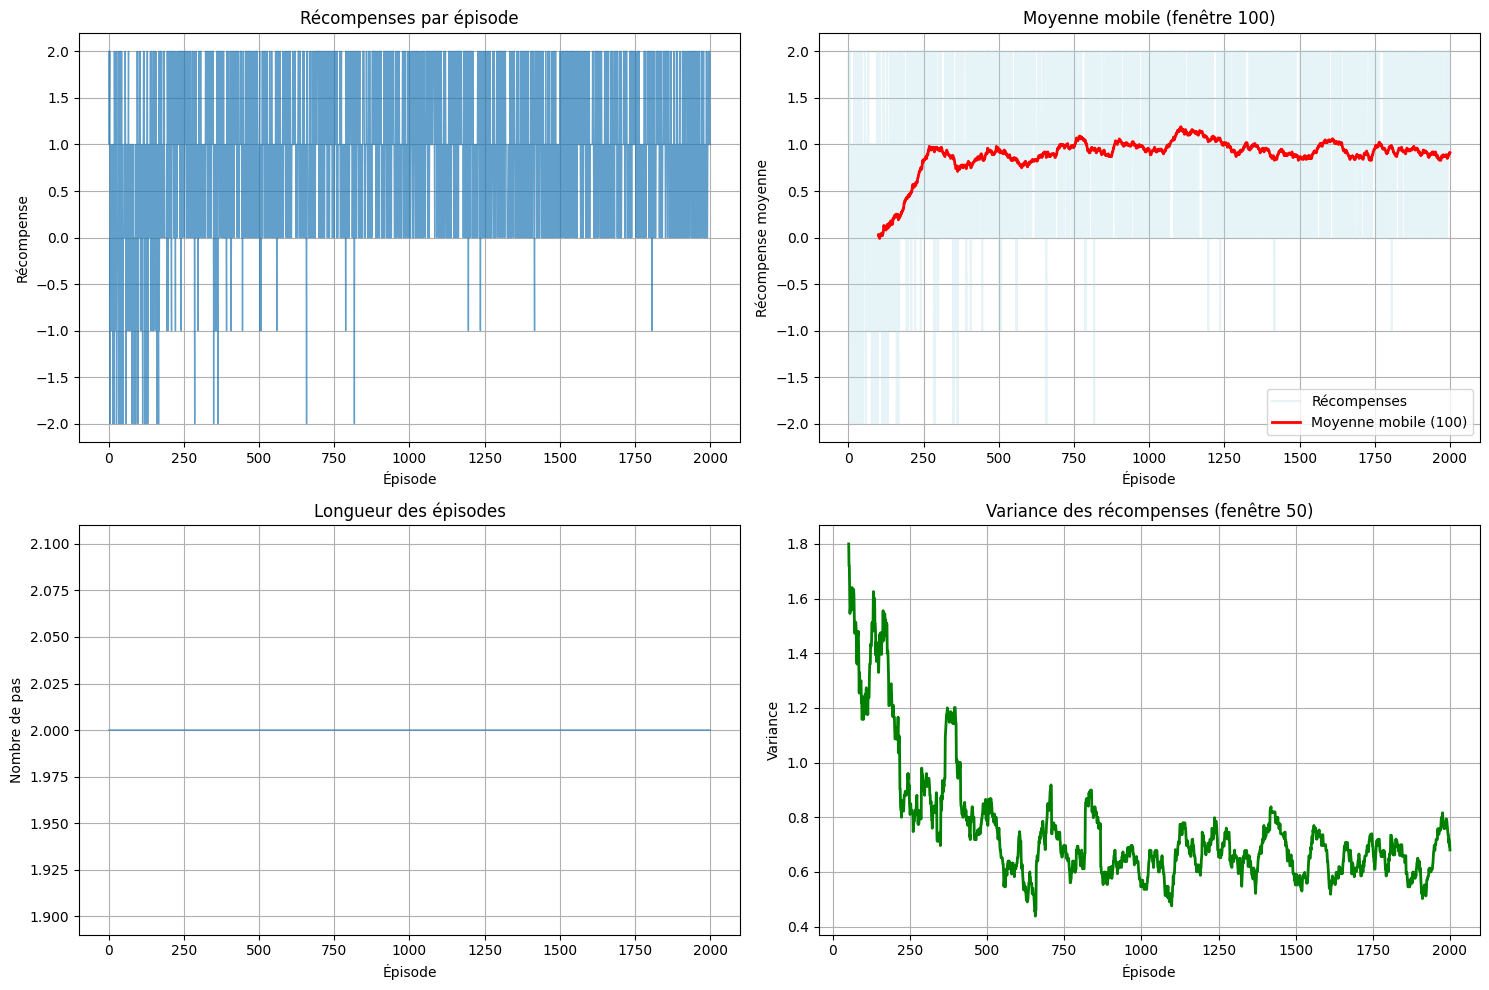

In [42]:
algorithm_off_mc_rps.plot_training_curves()

L'agent apprend également l'environnement et converge assez rapidement vers une politique optimale
Récompense moyenne de 1.01 et Taux de réussite à 67.3%

In [43]:
#Sauvegarde modèle
algorithm_off_mc_rps.save_model(filepath = "outputs/rps/modèle/off_monte_carlo.pkl")

#Sauvegarde résultats
agent_off_mc_rps.save_results(filepath = "outputs/rps/results/off_monte_carlo")

✅ Résultats sauvegardés: outputs/rps/results/off_monte_carlo_agent_results.pkl


True

In [93]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = OffPolicyMCControl(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/off_monte_carlo.pkl")
agent_off_mc_rps_ent = Agent(algo_sauv, env_rps, "Agent_off_mc_rps_entraine")

✅ Agent créé: Agent_off_mc_rps_entraine


In [94]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_off_mc_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_off_monte_carlo.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())

# Sarsa

In [51]:
config_sarsa = {
    'learning_rate': 0.2,
    'gamma': 0.95,
    'epsilon': 1
}
    
algorithm_sarsa_rps = SARSA.from_config(config_sarsa, env_rps)
algorithm_sarsa_rps.train(env_rps, num_episodes=2000, verbose=False)
    
agent_sarsa_rps = Agent(algorithm_sarsa_rps, env_rps, "Agent_sarsa_rps")

✅ Agent créé: Agent_sarsa_rps


In [52]:
print(algorithm_sarsa_rps.visualize_q_table())


Q-TABLE - SARSA
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.36         0.25         0.93         2         0.93      
1     0.00         1.00         -0.79        1         1.00      
2     0.00         1.00         -0.89        1         1.00      
3     0.00         1.00         -0.97        1         1.00      
4     -0.91        0.00         1.00         2         1.00      
5     -0.59        0.00         1.00         2         1.00      
6     -0.93        0.00         1.00         2         1.00      
7     1.00         -0.74        0.00         0         1.00      
8     1.00         -0.67        0.00         0         1.00      
9     1.00         -0.59        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [53]:
agent_sarsa_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=1000)


📊 ÉVALUATION: Agent_sarsa_rps
Épisodes d'évaluation: 1000
Progression: 10% - Récompense moyenne: 0.93
Progression: 20% - Récompense moyenne: 0.94
Progression: 30% - Récompense moyenne: 1.01
Progression: 40% - Récompense moyenne: 1.01
Progression: 50% - Récompense moyenne: 1.01
Progression: 60% - Récompense moyenne: 0.98
Progression: 70% - Récompense moyenne: 0.98
Progression: 80% - Récompense moyenne: 0.99
Progression: 90% - Récompense moyenne: 1.00
Progression: 100% - Récompense moyenne: 0.99

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 0.99 ± 0.82
Taux de succès: 66.0% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.02s



{'agent_name': 'Agent_sarsa_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 1000,
 'avg_reward': np.float64(0.993),
 'std_reward': np.float64(0.8203359068089121),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.66,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.017344236373901367,
 'timestamp': '2025-07-20T03:59:15.777608'}

[1.0, -1.0, 1.0, -1.0, 2.0, 0.0, 1.0, -1.0, 0.0, 1.0, -2.0, 0.0, 0.0, -1.0, 0.0, 2.0, 0.0, 0.0, 0.0, -2.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, -2.0, 2.0, 0.0, -1.0, -1.0, -1.0, 1.0, -2.0, -2.0, -1.0, 2.0, 1.0, 2.0, 0.0, -1.0, 2.0, 0.0, -1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, -1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0, 2.0, -1.0, 1.0, -2.0, -2.0, -1.0, 2.0, 0.0, -2.0, 0.0, 0.0, 1.0, 0.0, 0.0, -2.0, 2.0, 0.0, 0.0, 0.0, 0.0, -2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, -2.0, 1.0, 1.0, 1.0, 2.0, 0.0, -2.0, 0.0, -1.0, 0.0, -2.0, 0.0, 1.0, 2.0, 0.0, 2.0, -1.0, 1.0, 1.0, -2.0, 1.0, -1.0, 0.0, -2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, -1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, -2.0, 2.0, 1.0, -1.0, 2.0, 1.0, 0.0, -1.0, -1.0, 0.0, -2.0, 2.0, 0.0, -1.0, -2.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 2.0, 1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, -1.0, 2.0, 2.0, -2.0, 2.0, 2.0, -1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, -1.0,

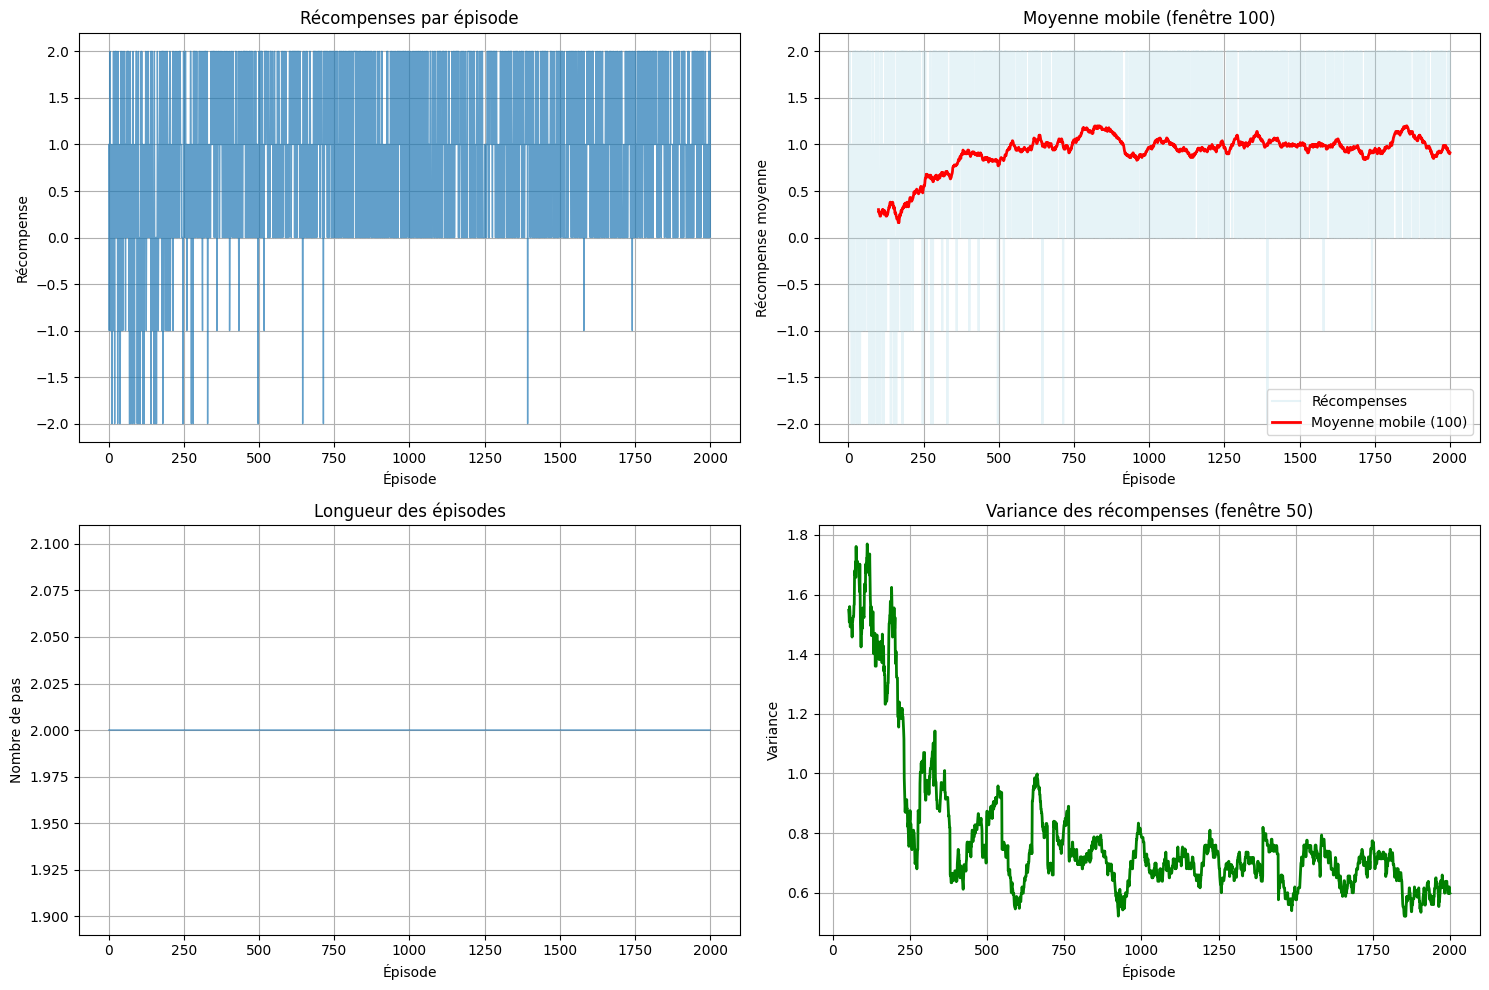

In [54]:
algorithm_sarsa_rps.plot_training_curves()

Agent apprend bien. converge mais a besoin de plus d'épisodes pour se stabiliser
Récompense moyenne de 0.99 et Taux de réussite à 66%

In [55]:
#Sauvegarde modèle
algorithm_sarsa_rps.save_model(filepath = "outputs/rps/modèle/sarsa.pkl")

#Sauvegarde résultats
agent_sarsa_rps.save_results(filepath = "outputs/rps/results/sarsa")

✅ Résultats sauvegardés: outputs/rps/results/sarsa_agent_results.pkl


True

In [95]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = SARSA(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/sarsa.pkl")
agent_sarsa_rps_ent = Agent(algo_sauv, env_rps, "Agent_sarsa_rps_entraine")

✅ Agent créé: Agent_sarsa_rps_entraine


In [96]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_sarsa_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_sarsa.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())

# Q_learning

Les hyperparamètres:
- learning_rate: float
Contrôle à quelle vitesse les nouvelles informations remplacent les anciennes.
Plage typique : 0.01 à 0.5
Trop petit : apprentissage lent
Trop grand : instabilité
L’agent n’apprend pas (les Q-values ne changent pas beaucoup) → augmenter α
L’apprentissage est instable / oscillant → réduire α
Commencer à 0.2 et ajuste selon la stabilité des récompenses.

- gamma: float
Pondère l’importance des récompenses futures.
Plage typique : 0.9 à 0.99
γ proche de 0 → myope (récompenses immédiates)
γ proche de 1 → long terme
L’agent a besoin de penser long terme (ex: Monty Hall) → utiliser γ ≈ 0.99
Tu veux un comportement plus court-terme → γ ≈ 0.9
Dans la plupart des cas, 0.95 est un bon point de départ.

- epsilon: float 
Utilisé dans la stratégie ε-greedy pour équilibrer exploration vs exploitation.
Plage typique : 0.1 à 0.3
Peut être fixe ou décroissant au fil du temps (epsilon decay)
L’agent stagne à une politique sous-optimale → remonter ε ou ralentir la décroissance
L’agent met trop de temps à converger → réduire ε plus vite
Valeur initiale typique : 1.0 (100% exploration au début)
EXPLORATION avec epsilon
EXPLOITATION avec 1-epsilon

- epsilon_decay
Vitesse à laquelle ε diminue
0.99 à 0.9999 par épisode

- Nombre d'épisodes
Combien de fois l’agent explore et apprend l’environnement.
Dépend de la complexité de l’environnement
Valeur typique :
Simples : 500 à 2 000 épisodes (LineWorld, RPS)
Plus complexes : 5 000+ (Monty Hall niveau 2)
Courbe de récompense ne converge pas → augmenter les épisodes
Pour tester rapidement → commencer avec 500, puis augmenter

In [3]:
config_ql = {
    'learning_rate': 0.2,
    'gamma': 0.95,
    'epsilon': 1
}
    
algorithm_ql_rps = QLearning.from_config(config_ql, env_rps)
algorithm_ql_rps.train(env_rps, num_episodes=1000, verbose=False)
    
agent_ql_rps = Agent(algorithm_ql_rps, env_rps, "Agent_ql_rps")

✅ Agent créé: Agent_ql_rps


In [4]:
print(algorithm_ql_rps.visualize_q_table())


Q-TABLE - QLearning
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.36         0.99         0.48         1         0.99      
1     0.00         1.00         -0.59        1         1.00      
2     0.00         1.00         -0.79        1         1.00      
3     0.00         1.00         -0.74        1         1.00      
4     -0.83        0.00         1.00         2         1.00      
5     -0.83        0.00         1.00         2         1.00      
6     -0.91        0.00         1.00         2         1.00      
7     1.00         -0.83        0.00         0         1.00      
8     1.00         -0.91        0.00         0         1.00      
9     1.00         -0.87        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [6]:
agent_ql_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=1000)


📊 ÉVALUATION: Agent_ql_rps
Épisodes d'évaluation: 1000
Progression: 10% - Récompense moyenne: 0.94
Progression: 20% - Récompense moyenne: 0.97
Progression: 30% - Récompense moyenne: 0.94
Progression: 40% - Récompense moyenne: 0.96
Progression: 50% - Récompense moyenne: 0.95
Progression: 60% - Récompense moyenne: 0.94
Progression: 70% - Récompense moyenne: 0.94
Progression: 80% - Récompense moyenne: 0.95
Progression: 90% - Récompense moyenne: 0.95
Progression: 100% - Récompense moyenne: 0.96

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 0.96 ± 0.81
Taux de succès: 65.1% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.02s



{'agent_name': 'Agent_ql_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 1000,
 'avg_reward': np.float64(0.963),
 'std_reward': np.float64(0.812176704910945),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.651,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.016202211380004883,
 'timestamp': '2025-07-19T22:34:06.937591'}

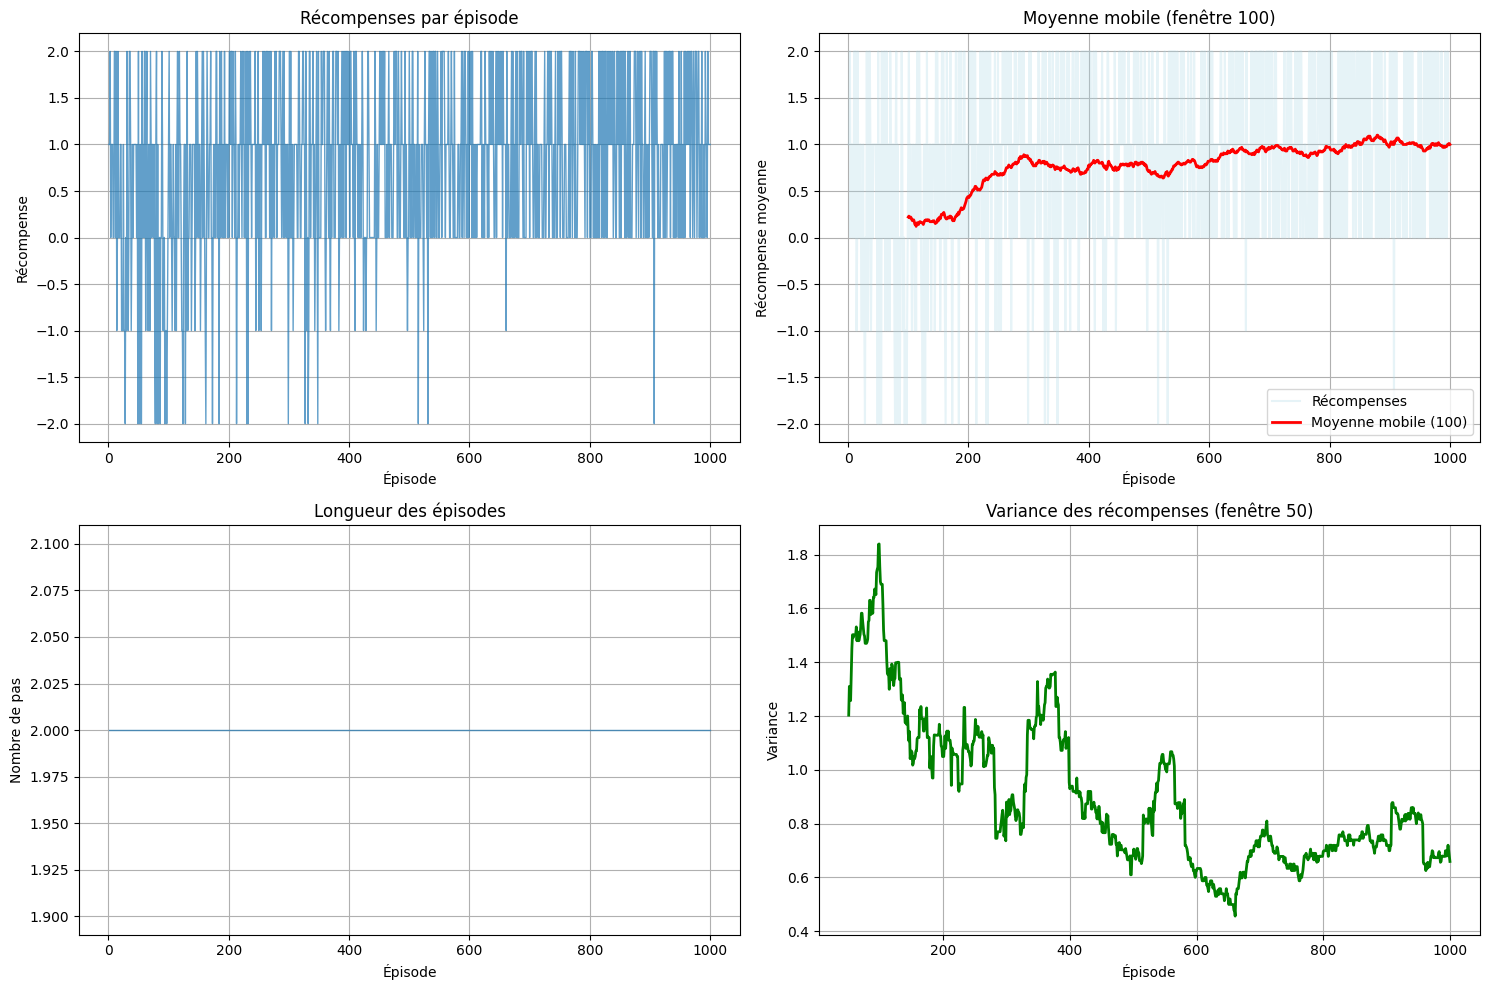

In [5]:
algorithm_ql_rps.plot_training_curves()

Phase initiale : forte exploration, récompenses très variables, moyenne autour de 0
Apprentissage : l’agent découvre progressivement la stratégie optimale, mène à une moyenne mobile en augmentation vers 1
Convergence : la moyenne se stabilise assez vite (300 épisodes) entre 0.8 et 1.1, tandis que la variance diminue; stratégie bien apprise
Longueur d’épisode est stable à 2 → pas d’anomalies dans l’environnement

La phase d'exploration est quand même très grande (environ 919 épisodes). Diminuons la phase d'exploration

In [16]:
config_ql_m = {
    'learning_rate': 0.2,
    'gamma': 0.95,
    'epsilon': 1,
    'epsilon_decay': 0.99
}
    
algorithm_ql_rps_m = QLearning.from_config(config_ql_m, env_rps)
algorithm_ql_rps_m.train(env_rps, num_episodes=1000, verbose=False)
    
agent_ql_rps_m = Agent(algorithm_ql_rps_m, env_rps, "Agent_ql_rps")
print(algorithm_ql_rps_m.visualize_q_table())

✅ Agent créé: Agent_ql_rps

Q-TABLE - QLearning
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.34         0.09         1.17         2         1.17      
1     0.00         0.67         -0.49        1         0.67      
2     0.00         0.89         -0.49        1         0.89      
3     0.00         0.00         0.00         0         0.00      
4     -0.83        0.00         1.00         2         1.00      
5     -0.67        0.00         1.00         2         1.00      
6     -0.79        0.00         1.00         2         1.00      
7     1.00         -0.79        0.00         0         1.00      
8     1.00         -0.67        0.00         0         1.00      
9     1.00         -0.59        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [17]:
agent_ql_rps_m.evaluate_performance(success_criterion = "positive_reward", num_episodes=1000)


📊 ÉVALUATION: Agent_ql_rps
Épisodes d'évaluation: 1000
Progression: 10% - Récompense moyenne: 0.91
Progression: 20% - Récompense moyenne: 0.94
Progression: 30% - Récompense moyenne: 0.95
Progression: 40% - Récompense moyenne: 0.97
Progression: 50% - Récompense moyenne: 0.96
Progression: 60% - Récompense moyenne: 0.99
Progression: 70% - Récompense moyenne: 0.99
Progression: 80% - Récompense moyenne: 0.99
Progression: 90% - Récompense moyenne: 0.99
Progression: 100% - Récompense moyenne: 0.99

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 0.99 ± 0.80
Taux de succès: 67.3% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.02s



{'agent_name': 'Agent_ql_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 1000,
 'avg_reward': np.float64(0.992),
 'std_reward': np.float64(0.803701437102112),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.673,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.01704692840576172,
 'timestamp': '2025-07-20T02:29:43.263382'}

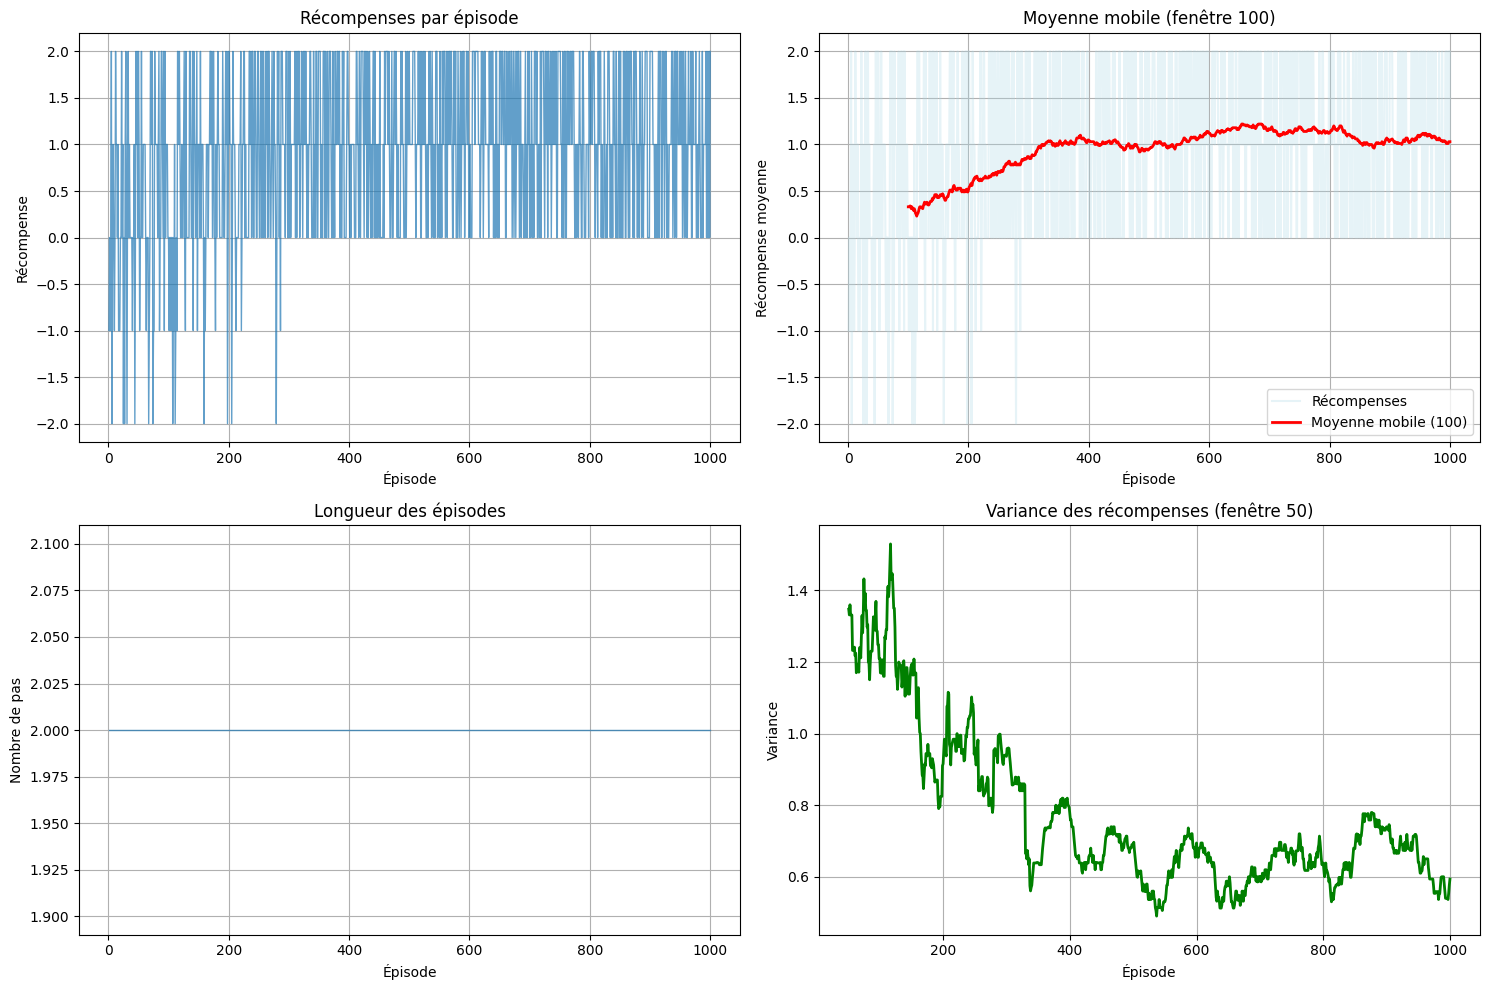

In [14]:
algorithm_ql_rps_m.plot_training_curves()

L'agent apprend très bien la politique optimale même avec un temps d'exploration plus court
Récompense moyenne de 0.99 et Taux de réussite à 67.3%

In [18]:
#Sauvegarde modèle
algorithm_ql_rps_m.save_model(filepath = "outputs/rps/modèle/q_learning.pkl")

#Sauvegarde résultats
agent_ql_rps_m.save_results(filepath = "outputs/rps/results/q_learning")

✅ Résultats sauvegardés: outputs/rps/results/q_learning_agent_results.pkl


True

In [97]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = QLearning(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/q_learning.pkl")
agent_ql_rps_ent = Agent(algo_sauv, env_rps, "Agent_ql_rps_entraine")

✅ Agent créé: Agent_ql_rps_entraine


In [98]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_ql_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_q_learning.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())

# Dyna Q

In [76]:
config_dynaq = {
    'learning_rate': 0.2,
    'gamma': 0.95,
    'epsilon': 1
}
    
algorithm_dynaq_rps = DynaQ.from_config(config_dynaq, env_rps)
algorithm_dynaq_rps.train(env_rps, num_episodes=2000, verbose=False)
    
agent_dynaq_rps = Agent(algorithm_dynaq_rps, env_rps, "Agent_dynaq_rps")

✅ Agent créé: Agent_dynaq_rps


In [77]:
print(algorithm_dynaq_rps.visualize_q_table())


Q-TABLE - DynaQ
État  Action0       Action1       Action2       Politique Valeur    
--------------------------------------------------
0     0.38         -0.05        -0.05        0         0.38      
1     0.00         1.00         -1.00        1         1.00      
2     0.00         1.00         -1.00        1         1.00      
3     0.00         1.00         -1.00        1         1.00      
4     -1.00        0.00         1.00         2         1.00      
5     -1.00        0.00         1.00         2         1.00      
6     -1.00        0.00         1.00         2         1.00      
7     1.00         -1.00        0.00         0         1.00      
8     1.00         -1.00        0.00         0         1.00      
9     1.00         -1.00        0.00         0         1.00      
10    0.00         0.00         0.00         0         0.00      



In [78]:
agent_dynaq_rps.evaluate_performance(success_criterion = "positive_reward", num_episodes=2000)


📊 ÉVALUATION: Agent_dynaq_rps
Épisodes d'évaluation: 2000
Progression: 10% - Récompense moyenne: 0.93
Progression: 20% - Récompense moyenne: 1.00
Progression: 30% - Récompense moyenne: 1.01
Progression: 40% - Récompense moyenne: 0.99
Progression: 50% - Récompense moyenne: 0.99
Progression: 60% - Récompense moyenne: 0.99
Progression: 70% - Récompense moyenne: 0.99
Progression: 80% - Récompense moyenne: 1.00
Progression: 90% - Récompense moyenne: 0.99
Progression: 100% - Récompense moyenne: 0.99

✅ RÉSULTATS:
Environnement: TwoRoundRPSEnvironment
Récompense moyenne: 0.99 ± 0.82
Taux de succès: 65.3% (critère: positive_reward)
Longueur moyenne: 2.0 étapes
Temps d'évaluation: 0.04s



{'agent_name': 'Agent_dynaq_rps',
 'environment': 'TwoRoundRPSEnvironment',
 'num_episodes': 2000,
 'avg_reward': np.float64(0.986),
 'std_reward': np.float64(0.8245022741023824),
 'min_reward': np.float64(0.0),
 'max_reward': np.float64(2.0),
 'avg_episode_length': np.float64(2.0),
 'success_rate': 0.653,
 'success_criterion': 'positive_reward',
 'evaluation_time': 0.03588509559631348,
 'timestamp': '2025-07-20T04:16:29.601852'}

[2.0, 1.0, 1.0, 2.0, -1.0, 0.0, 2.0, 2.0, -1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, -1.0, -1.0, 0.0, 1.0, -2.0, 1.0, 1.0, -1.0, 1.0, 0.0, 1.0, 1.0, 2.0, -1.0, -2.0, 0.0, 0.0, 2.0, -2.0, 1.0, -1.0, 1.0, 0.0, 0.0, -1.0, 1.0, 1.0, 0.0, -1.0, 0.0, 1.0, -1.0, 1.0, 0.0, 0.0, -1.0, 2.0, 0.0, 2.0, 1.0, -2.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, -1.0, 2.0, 1.0, -1.0, 2.0, 1.0, 0.0, 0.0, 2.0, -1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, -1.0, -1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, 2.0, -2.0, 1.0, -2.0, 1.0, 0.0, 1.0, -2.0, -2.0, 2.0, 0.0, -1.0, -1.0, 2.0, 1.0, -1.0, 2.0, -1.0, 0.0, 1.0, 1.0, 0.0, 0.0, -1.0, 0.0, 2.0, 1.0, 1.0, -1.0, 2.0, -1.0, 2.0, 1.0, 2.0, 1.0, 2.0, -1.0, -1.0, 1.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, -2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, -2.0, 1.0, -2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, -2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, -1

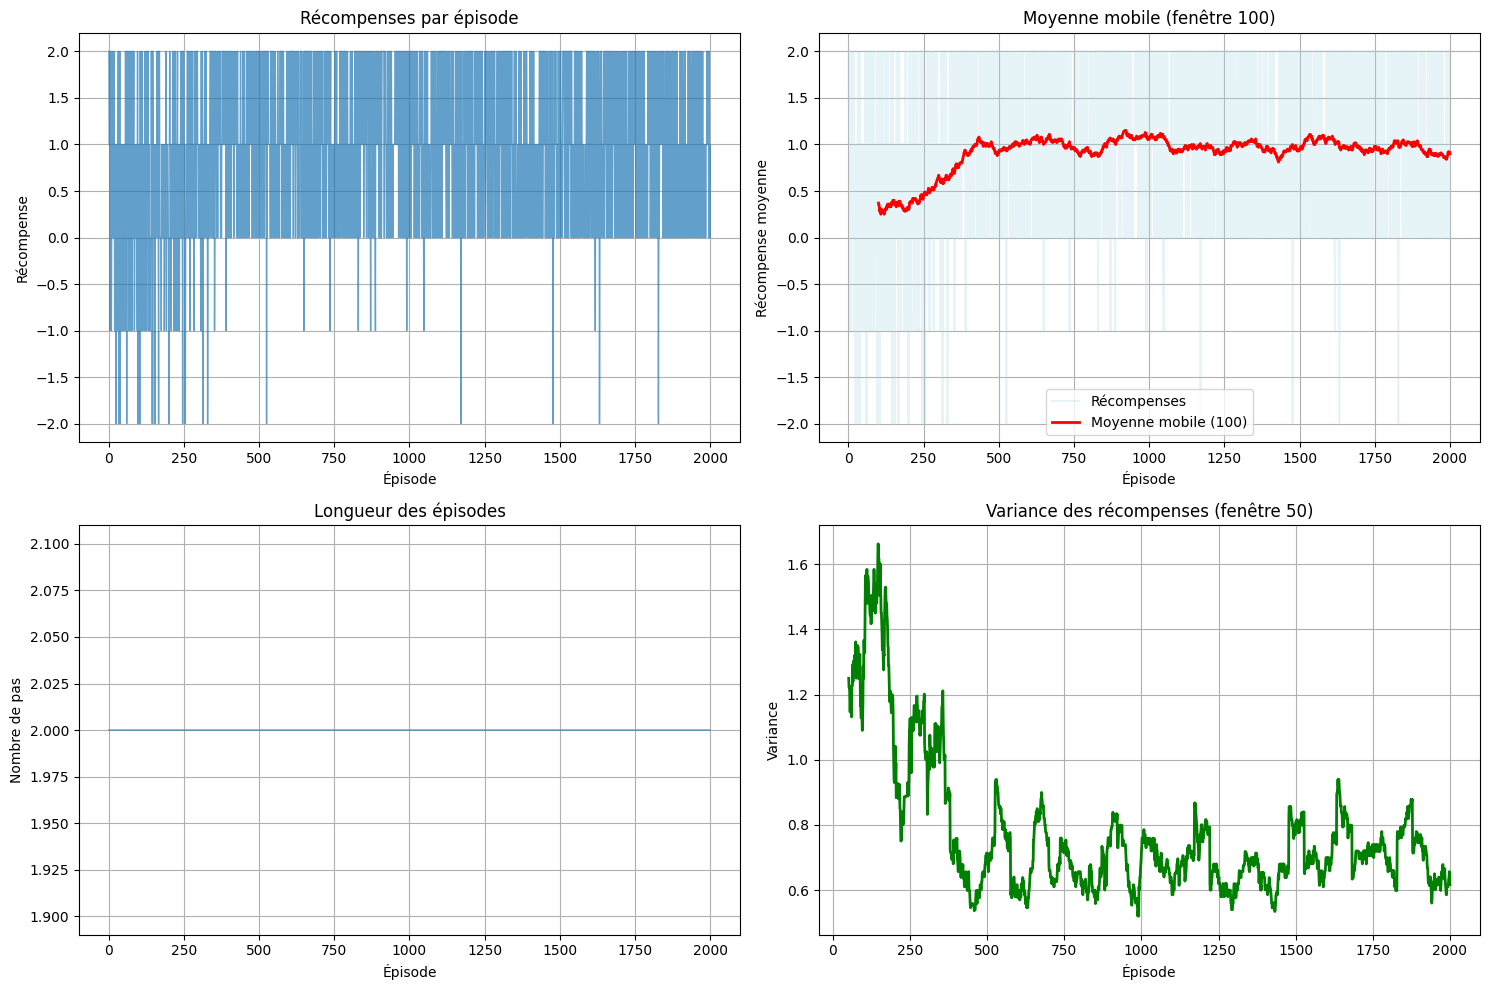

In [79]:
algorithm_dynaq_rps.plot_training_curves()

agent apprend parfaitement
Récompense moyenne de 0.99 et Taux de réussite à 65.3%

In [80]:
#Sauvegarde modèle
algorithm_dynaq_rps.save_model(filepath = "outputs/rps/modèle/dyna_q.pkl")

#Sauvegarde résultats
agent_dynaq_rps.save_results(filepath = "outputs/rps/results/dyna_q")

✅ Résultats sauvegardés: outputs/rps/results/dyna_q_agent_results.pkl


True

In [99]:
#Chargement du modèle sauvegardé et création agent entraîné
algo_sauv = DynaQ(
        state_space_size=env_rps.state_space_size,
        action_space_size=env_rps.action_space_size)
algo_sauv.load_model(filepath = "outputs/rps/modèle/dyna_q.pkl")
agent_dynaq_rps_ent = Agent(algo_sauv, env_rps, "Agent_dynaq_rps_entraine")

✅ Agent créé: Agent_dynaq_rps_entraine


In [100]:
#Démonstrattion pas à pas

# Rediriger stdout vers un buffer
old_stdout = sys.stdout
buffer = io.StringIO()
sys.stdout = buffer

# Appeler ta fonction de démonstration
agent_dynaq_rps_ent.demonstrate_step_by_step(num_episodes = 1)

# Restaurer stdout
sys.stdout = old_stdout

# Écrire dans un fichier
with open("outputs/rps/demo_pas_à_pas/demo_dyna_q.txt", "w", encoding="utf-8") as f:
    f.write(buffer.getvalue())